I am implementing RViT (https://github.com/Jiewen-Yang/RViT). The Recurrent Dropout technique will be applied to the output of the attention gate, focusing on the hidden state updates. By utilizing per-step mask sampling, we ensure that the model’s recurrent connections are regularized effectively, preventing overfitting while preserving temporal dependencies over long sequences. This approach mitigates the risk of memory loss, which is a common issue in standard recurrent models when dropout is applied incorrectly. Also, i aim to use this final model will be extended to perform video predictions, utilizing the learned temporal dynamics to fore- cast future frames in video sequences.

In [2]:
import os
import csv
import subprocess
import random
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [4]:
pwd

'c:\\Users\\jeffr\\OneDrive\\Documents\\GitHub\\CS593'

In [6]:
# Paths
base_path = "c:\\Users\\jeffr\\OneDrive\\Documents\\GitHub\\CS593"
resized_videos_path = os.path.join(base_path, 'resized_videos')
processed_frames_path = os.path.join(base_path, 'processed_frames')
train_csv = os.path.join(base_path, 'train_annotations.csv')
val_csv = os.path.join(base_path, 'val_annotations.csv')

In [3]:
def resize_videos(input_folder, output_folder, resolution=(256, 256)):
    os.makedirs(output_folder, exist_ok=True)
    for label_folder in os.listdir(input_folder):
        if label_folder.startswith('.'):  # Skip hidden files
            continue
        label_input_path = os.path.join(input_folder, label_folder)
        if not os.path.isdir(label_input_path):
            continue
        label_output_path = os.path.join(output_folder, label_folder)
        os.makedirs(label_output_path, exist_ok=True)
        for video_file in os.listdir(label_input_path):
            if not video_file.endswith('.mp4'):  # Handle only .mp4 files
                continue
            input_video_path = os.path.join(label_input_path, video_file)
            output_video_path = os.path.join(label_output_path, video_file)
            # Resize using ffmpeg
            cmd = f"ffmpeg -i '{input_video_path}' -vf scale={resolution[0]}:{resolution[1]} '{output_video_path}'"
            result = subprocess.run(cmd, shell=True, stderr=subprocess.PIPE)
            if result.returncode != 0:
                print(f"Error resizing {input_video_path}: {result.stderr.decode()}")


In [4]:
import os
import random
import subprocess

def resize_videos(input_folder, output_folder, resolution=(256, 256), num_folders=50):
    # Get all subfolders in the input folder
    all_folders = [folder for folder in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, folder))]
    if len(all_folders) < num_folders:
        print(f"Not enough folders to select {num_folders}. Proceeding with all available folders.")
        selected_folders = all_folders
    else:
        selected_folders = random.sample(all_folders, num_folders)  # Randomly select folders

    os.makedirs(output_folder, exist_ok=True)

    for label_folder in selected_folders:
        label_input_path = os.path.join(input_folder, label_folder)
        label_output_path = os.path.join(output_folder, label_folder)
        os.makedirs(label_output_path, exist_ok=True)

        for video_file in os.listdir(label_input_path):
            if not video_file.endswith('.mp4'):  # Handle only .mp4 files
                continue
            input_video_path = os.path.join(label_input_path, video_file)
            output_video_path = os.path.join(label_output_path, video_file)
            # Resize using ffmpeg
            cmd = f"ffmpeg -i '{input_video_path}' -vf scale={resolution[0]}:{resolution[1]} '{output_video_path}'"
            result = subprocess.run(cmd, shell=True, stderr=subprocess.PIPE)
            if result.returncode != 0:
                print(f"Error resizing {input_video_path}: {result.stderr.decode()}")

# Example usage
# input_folder = '/kaggle/input/kinetics-train-5per/kinetics400_5per/kinetics400_5per/train'
# output_folder = '/kaggle/output/resized_videos'
# resize_videos(input_folder, output_folder, resolution=(256, 256), num_folders=50)
resize_videos(os.path.join(base_path, 'train'), resized_videos_path, resolution=(256, 256), num_folders=50)

KeyboardInterrupt: 

In [20]:
import cv2
import os

def extract_informative_frames_from_folders(input_folder, output_folder, fps=5, threshold=30):
    """
    Extracts frames with significant motion from all videos in labeled folders.

    Parameters:
    - input_folder: Path to the root folder containing labeled video folders.
    - output_folder: Path to save extracted frames organized by labels.
    - fps: Number of frames per second to sample.
    - threshold: Motion threshold to detect significant changes.
    """
    os.makedirs(output_folder, exist_ok=True)

    # Iterate through all label folders
    for label_folder in os.listdir(input_folder):
        label_input_path = os.path.join(input_folder, label_folder)
        if not os.path.isdir(label_input_path):
            continue

        label_output_path = os.path.join(output_folder, label_folder)
        os.makedirs(label_output_path, exist_ok=True)

        # Process all .mp4 files in the label folder
        for video_file in os.listdir(label_input_path):
            if not video_file.endswith('.mp4'):
                continue

            video_path = os.path.join(label_input_path, video_file)
            video_output_path = os.path.join(label_output_path, os.path.splitext(video_file)[0])
            os.makedirs(video_output_path, exist_ok=True)

            cap = cv2.VideoCapture(video_path)
            prev_frame = None
            frame_count = 0
            saved_frame_count = 0
            frame_rate = cap.get(cv2.CAP_PROP_FPS)
            if frame_rate == 0 or frame_rate is None:
                print(f"Skipping {video_path} due to unreadable frame rate.")
                continue

            interval = int(frame_rate / fps)

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_count += 1
                if frame_count % interval != 0:
                    continue

                gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                if prev_frame is not None:
                    diff = cv2.absdiff(prev_frame, gray_frame)
                    motion_score = diff.mean()

                    if motion_score > threshold:
                        frame_filename = os.path.join(video_output_path, f"frame_{saved_frame_count:04d}.jpg")
                        cv2.imwrite(frame_filename, frame)
                        saved_frame_count += 1

                prev_frame = gray_frame

            cap.release()
            print(f"Extracted {saved_frame_count} frames with significant motion from {video_path}")


In [21]:
extract_informative_frames_from_folders(resized_videos_path, processed_frames_path, fps=5, threshold=30)


Extracted 0 frames with significant motion from /Users/junghwang/Documents/CS593/PROJ/kinetics400/resized_videos/giving or receiving award/JBWeDivEHFI.mp4
Extracted 1 frames with significant motion from /Users/junghwang/Documents/CS593/PROJ/kinetics400/resized_videos/giving or receiving award/LUkrMckP4EI.mp4
Extracted 0 frames with significant motion from /Users/junghwang/Documents/CS593/PROJ/kinetics400/resized_videos/giving or receiving award/sjamWV2-gxU.mp4
Extracted 0 frames with significant motion from /Users/junghwang/Documents/CS593/PROJ/kinetics400/resized_videos/giving or receiving award/r_dQ0SOQ9z0.mp4
Extracted 8 frames with significant motion from /Users/junghwang/Documents/CS593/PROJ/kinetics400/resized_videos/giving or receiving award/Oxe8beZkZws.mp4
Extracted 27 frames with significant motion from /Users/junghwang/Documents/CS593/PROJ/kinetics400/resized_videos/giving or receiving award/apO64ogqiY0.mp4
Extracted 1 frames with significant motion from /Users/junghwang/Docu

In [36]:
# Run preprocessing
resize_videos(os.path.join(base_path, 'train'), resized_videos_path, resolution=(256, 256))

In [ ]:
video_path = "/path/to/video.mp4"
output_folder = "/path/to/output/frames"
extract_informative_frames(resized_videos_path, processed_frames_path, fps=5, threshold=30)


In [6]:
# Extract frames from resized videos
extract_frames_ffmpeg(resized_videos_path, processed_frames_path, fps=5)

ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 16.0.0 (clang-1600.0.26.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --e

In [25]:
def log_directory_structure(base_path):
    for root, dirs, files in os.walk(base_path):
        print(f"Directory: {root}")
        if dirs:
            print(f"  Subdirectories: {dirs}")
        if files:
            print(f"  Files: {files}")


In [44]:
log_directory_structure(resized_videos_path)
log_directory_structure(processed_frames_path)


Directory: /Users/junghwang/Documents/CS593/PROJ/kinetics400/resized_videos
  Subdirectories: ['answering questions', 'air drumming', 'applauding', 'abseiling', 'applying cream', 'archery']
Directory: /Users/junghwang/Documents/CS593/PROJ/kinetics400/resized_videos/answering questions
  Files: ['j6ogVLOLQug.mp4', '7scGpjeIzk8.mp4', '6Am-TQ0OeFU.mp4', 'Jt14GR8BnKw.mp4', 'joN6_IGDa0U.mp4', 'Jt-ac6pstmM.mp4', '8hYoYEHAk-c.mp4', 'ny_4DKE5_AI.mp4', '_EfhVLCy3Y4.mp4', 'z6HJ-dPQ_6M.mp4', 'ktYRoTTTGPA.mp4', '_VaBR4wdZI0.mp4', 'AqVyP5BkEsA.mp4']
Directory: /Users/junghwang/Documents/CS593/PROJ/kinetics400/resized_videos/air drumming
  Files: ['5M80ZTWfzOU.mp4', 'ETlP-ui-WuE.mp4', '_wSslwn5Xuc.mp4', 'ebYDs8g3n2Q.mp4', '5vsvvC3URCI.mp4', 'Ob-VYqPMlxM.mp4', '0ETN_KBzW_c.mp4', 'cjSPyzOaxIg.mp4', 'rOxGtBTjINQ.mp4', 'gFI4lkq3rqk.mp4', 'JvqAqpzobFg.mp4', 'Iy7Fqb_IE10.mp4', 'ebduwpFg3Y4.mp4', 'nQPz3V8noXs.mp4', 'UHD-eXFtxCE.mp4', 'DNXNsDRCLtE.mp4', 'NU6rLgL2228.mp4', 'CErkhE_nKZs.mp4', 'vAay-r4fBVg.mp4

In [26]:
import os
import random
import csv

def create_train_val_annotations(frames_folder, train_csv, val_csv, val_split=0.2):
    """
    Generate training and validation annotation files from the extracted frames directory.

    Args:
        frames_folder (str): Path to the folder containing processed frames.
        train_csv (str): Output path for the training annotation CSV file.
        val_csv (str): Output path for the validation annotation CSV file.
        val_split (float): Fraction of data to allocate for validation.
    """
    all_annotations = []

    # Iterate through each label (category) folder
    for label_folder in os.listdir(frames_folder):
        label_path = os.path.join(frames_folder, label_folder)
        
        # Skip non-directory or hidden files
        if not os.path.isdir(label_path) or label_folder.startswith('.'):
            continue

        # Iterate through each video (frame folder) within the label folder
        for frame_folder in os.listdir(label_path):
            frame_folder_path = os.path.join(label_path, frame_folder)
            
            # Skip non-directory or hidden files
            if not os.path.isdir(frame_folder_path) or frame_folder.startswith('.'):
                continue

            # Append frame folder path and corresponding label
            all_annotations.append((frame_folder_path, label_folder))

    # Shuffle and split into train and validation sets
    random.shuffle(all_annotations)
    split_idx = int(len(all_annotations) * (1 - val_split))
    train_annotations = all_annotations[:split_idx]
    val_annotations = all_annotations[split_idx:]

    # Write training annotations to CSV
    with open(train_csv, 'w', newline='') as train_file:
        writer = csv.writer(train_file)
        writer.writerow(['frame_folder', 'label'])  # Write header
        writer.writerows(train_annotations)

    # Write validation annotations to CSV
    with open(val_csv, 'w', newline='') as val_file:
        writer = csv.writer(val_file)
        writer.writerow(['frame_folder', 'label'])  # Write header
        writer.writerows(val_annotations)

    print(f"Annotations created: {len(train_annotations)} training and {len(val_annotations)} validation samples.")


In [27]:
import os

def print_directory_structure(base_path):
    for root, dirs, files in os.walk(base_path):
        print(f"Directory: {root}")
        if dirs:
            print(f"  Subdirectories: {dirs}")
        if files:
            print(f"  Files: {files}")

print_directory_structure('/Users/junghwang/Documents/CS593/PROJ/kinetics400/processed_frames')


Directory: /Users/junghwang/Documents/CS593/PROJ/kinetics400/processed_frames
  Subdirectories: ['answering questions', 'air drumming', 'applauding', 'abseiling', 'applying cream', 'archery']
  Files: ['.DS_Store']
Directory: /Users/junghwang/Documents/CS593/PROJ/kinetics400/processed_frames/answering questions
  Files: ['Jt-ac6pstmM_frame_0001.jpg', 'Jt-ac6pstmM_frame_0015.jpg', 'Jt-ac6pstmM_frame_0029.jpg', 'z6HJ-dPQ_6M_frame_0006.jpg', 'AqVyP5BkEsA_frame_0043.jpg', 'j6ogVLOLQug_frame_0046.jpg', 'z6HJ-dPQ_6M_frame_0012.jpg', '7scGpjeIzk8_frame_0043.jpg', '8hYoYEHAk-c_frame_0043.jpg', 'joN6_IGDa0U_frame_0046.jpg', 'ny_4DKE5_AI_frame_0006.jpg', 'ny_4DKE5_AI_frame_0012.jpg', '_VaBR4wdZI0_frame_0045.jpg', '6Am-TQ0OeFU_frame_0018.jpg', '6Am-TQ0OeFU_frame_0030.jpg', '6Am-TQ0OeFU_frame_0024.jpg', '6Am-TQ0OeFU_frame_0025.jpg', '6Am-TQ0OeFU_frame_0031.jpg', '6Am-TQ0OeFU_frame_0019.jpg', '_VaBR4wdZI0_frame_0050.jpg', '_VaBR4wdZI0_frame_0044.jpg', 'ny_4DKE5_AI_frame_0013.jpg', 'ny_4DKE5_AI_fram

In [49]:
for label_folder in os.listdir(frames_folder):
    label_path = os.path.join(frames_folder, label_folder)
    if os.path.isdir(label_path) and not label_folder.startswith('.'):
        print(f"Valid label folder: {label_folder}")
    else:
        print(f"Invalid label folder: {label_folder}")


Valid label folder: answering questions
Valid label folder: air drumming
Valid label folder: applauding
Valid label folder: abseiling
Valid label folder: applying cream
Valid label folder: archery


In [7]:
def create_train_val_annotations(frames_folder, train_csv, val_csv, val_split=0.2):
    """
    Generate training and validation annotation files from the extracted frames directory
    for a structure where individual frames are stored directly under label folders.
    """
    all_annotations = []

    # Iterate through each label (category) folder
    for label_folder in os.listdir(frames_folder):
        label_path = os.path.join(frames_folder, label_folder)
        if not os.path.isdir(label_path) or label_folder.startswith('.'):
            print(f"Skipping invalid or hidden label folder: {label_folder}")
            continue

        # Iterate through each frame file within the label folder
        valid_frame_count = 0
        for frame_file in os.listdir(label_path):
            frame_file_path = os.path.join(label_path, frame_file)
            if not os.path.isfile(frame_file_path) or frame_file.startswith('.'):
                print(f"Skipping invalid or hidden frame file: {frame_file}")
                continue

            # Add frame file path and corresponding label
            valid_frame_count += 1
            print(f"Adding frame file: {frame_file_path}, Label: {label_folder}")
            all_annotations.append((frame_file_path, label_folder))

        if valid_frame_count == 0:
            print(f"No valid frame files found in label folder: {label_folder}")

    # Debug: Print collected annotations
    print(f"Collected {len(all_annotations)} annotations.")

    # Shuffle and split into train and validation sets
    if all_annotations:
        random.shuffle(all_annotations)
        split_idx = int(len(all_annotations) * (1 - val_split))
        train_annotations = all_annotations[:split_idx]
        val_annotations = all_annotations[split_idx:]
    else:
        train_annotations = []
        val_annotations = []

    # Debug: Print train/val split info
    print(f"Train annotations: {len(train_annotations)}")
    print(f"Validation annotations: {len(val_annotations)}")

    # Write training annotations to CSV
    with open(train_csv, 'w', newline='') as train_file:
        writer = csv.writer(train_file)
        writer.writerow(['frame_folder', 'label'])  # Write header
        writer.writerows(train_annotations)

    # Write validation annotations to CSV
    with open(val_csv, 'w', newline='') as val_file:
        writer = csv.writer(val_file)
        writer.writerow(['frame_folder', 'label'])  # Write header
        writer.writerows(val_annotations)

    print("Annotation CSVs created successfully.")


In [9]:
# Example usage:
# frames_folder = '/Users/junghwang/Documents/CS593/PROJ/kinetics400/processed_frames'
# train_csv = '/Users/junghwang/Documents/CS593/PROJ/kinetics400/train_annotations.csv'
# val_csv = '/Users/junghwang/Documents/CS593/PROJ/kinetics400/val_annotations.csv'

create_train_val_annotations(processed_frames_path, train_csv, val_csv)

Skipping invalid or hidden label folder: .DS_Store
Skipping invalid or hidden frame file: -WKCwDRp_jk
Adding frame file: c:\Users\jeffr\OneDrive\Documents\GitHub\CS593\processed_frames\abseiling\-WKCwDRp_jk_frame_0001.jpg, Label: abseiling
Adding frame file: c:\Users\jeffr\OneDrive\Documents\GitHub\CS593\processed_frames\abseiling\-WKCwDRp_jk_frame_0002.jpg, Label: abseiling
Adding frame file: c:\Users\jeffr\OneDrive\Documents\GitHub\CS593\processed_frames\abseiling\-WKCwDRp_jk_frame_0003.jpg, Label: abseiling
Adding frame file: c:\Users\jeffr\OneDrive\Documents\GitHub\CS593\processed_frames\abseiling\-WKCwDRp_jk_frame_0004.jpg, Label: abseiling
Adding frame file: c:\Users\jeffr\OneDrive\Documents\GitHub\CS593\processed_frames\abseiling\-WKCwDRp_jk_frame_0005.jpg, Label: abseiling
Adding frame file: c:\Users\jeffr\OneDrive\Documents\GitHub\CS593\processed_frames\abseiling\-WKCwDRp_jk_frame_0006.jpg, Label: abseiling
Adding frame file: c:\Users\jeffr\OneDrive\Documents\GitHub\CS593\proc

In [11]:
pwd

'c:\\Users\\jeffr\\OneDrive\\Documents\\GitHub\\CS593'

In [12]:
import pandas as pd

train_annotations = pd.read_csv('c:\\Users\\jeffr\\OneDrive\\Documents\\GitHub\\CS593\\train_annotations.csv')
val_annotations = pd.read_csv('c:\\Users\\jeffr\\OneDrive\\Documents\\GitHub\\CS593\\val_annotations.csv')

print("Train Annotations:")
print(train_annotations.head())

print("Validation Annotations:")
print(val_annotations.head())

Train Annotations:
                                        frame_folder            label
0  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...   opening bottle
1  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...     playing harp
2  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...  riding elephant
3  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...     throwing axe
4  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...     throwing axe
Validation Annotations:
                                        frame_folder             label
0  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...      throwing axe
1  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...  playing trombone
2  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...      air drumming
3  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...           archery
4  c:\Users\jeffr\OneDrive\Documents\GitHub\CS593...           archery


In [13]:
from PIL import Image
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class FrameDataset(Dataset):
    def __init__(self, annotations_file, transform=None, num_frames=16, label_to_index=None, base_dir=None):
        """
        Dataset for loading video frames.

        Parameters:
        - annotations_file: Path to the CSV file with frame paths and labels.
        - transform: Transformations to apply to each frame.
        - num_frames: Number of frames per sequence.
        - label_to_index: Mapping of label names to indices.
        - base_dir: Base directory for frame paths (optional).
        """
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform
        self.num_frames = num_frames
        self.label_to_index = label_to_index
        self.base_dir = base_dir  # Base directory for resolving frame paths

    def __len__(self):
        return len(self.annotations) // self.num_frames  # Each sample is a sequence of frames

    def __getitem__(self, idx):
        # Get the starting index for the sequence
        start_idx = idx * self.num_frames
        sequence_frames = self.annotations.iloc[start_idx:start_idx + self.num_frames]

        frames = []

        for frame_file in sequence_frames['frame_folder']:
            # Resolve full path for the frame
            frame_path = frame_file
            if self.base_dir and not os.path.isabs(frame_file):
                frame_path = os.path.join(self.base_dir, frame_file)

            if not os.path.exists(frame_path):
                raise FileNotFoundError(f"Frame not found: {frame_path}")

            frame = Image.open(frame_path).convert("RGB")
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)

        # Handle cases with fewer frames than num_frames
        if len(frames) < self.num_frames:
            pad_frames = [torch.zeros_like(frames[0])] * (self.num_frames - len(frames))
            frames.extend(pad_frames)

        # Handle cases with more frames than num_frames
        if len(frames) > self.num_frames:
            frames = frames[:self.num_frames]

        # Stack frames into a single tensor
        frames_tensor = torch.stack(frames, dim=0)

        # Retrieve the label
        label = sequence_frames.iloc[0]['label']
        if self.label_to_index:
            label = self.label_to_index[label]

        return frames_tensor, torch.tensor(label, dtype=torch.long)


In [14]:
# Create a mapping from label names to indices
label_to_index = {label: idx for idx, label in enumerate(sorted(os.listdir(processed_frames_path)))}
print(f"Label to Index Mapping: {label_to_index}")


Label to Index Mapping: {'.DS_Store': 0, 'abseiling': 1, 'air drumming': 2, 'answering questions': 3, 'applauding': 4, 'applying cream': 5, 'archery': 6, 'checking tires': 7, 'doing aerobics': 8, 'giving or receiving award': 9, 'juggling soccer ball': 10, 'kissing': 11, 'milking cow': 12, 'moving furniture': 13, 'opening bottle': 14, 'playing harp': 15, 'playing trombone': 16, 'pushing wheelchair': 17, 'riding elephant': 18, 'throwing axe': 19, 'waxing chest': 20, 'wrapping present': 21, 'wrestling': 22}


In [18]:
# Define transformation to match model requirements
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match model's image size
    transforms.ToTensor(),          # Convert to tensor
])

# Create train and validation datasets
train_dataset = FrameDataset(
    annotations_file=train_csv,
    transform=transform,
    num_frames=16,  # Number of frames per sequence
    label_to_index=label_to_index
)

val_dataset = FrameDataset(
    annotations_file=val_csv,
    transform=transform,
    num_frames=16,
    label_to_index=label_to_index
)
#short
# train_dataset = torch.utils.data.Subset(train_dataset, range(50))  # Use the first 50 samples
# val_dataset = torch.utils.data.Subset(val_dataset, range(20))  # Use the first 20 samples

# Print the lengths of your datasets to check for emptiness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Create DataLoaders

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=8)



Train Dataset Length: 1436
Validation Dataset Length: 359


In [41]:
for frames, labels in train_dataloader:
    print(f"Batch of frames shape: {frames.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")
    break


Batch of frames shape: torch.Size([2, 16, 3, 224, 224])
Batch of labels: tensor([20, 21])


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RViT(nn.Module):
    def __init__(self, num_classes, hidden_dim, num_layers, frame_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Patch embedding with reduced stride and kernel size
        self.patch_embedding = nn.Conv3d(16, hidden_dim, kernel_size=(3, 8, 8), stride=(3, 4, 4), padding=(1, 2, 2))
        
        # Simplified learnable position encoding
        # Adjust the temporal dimension to match the expected input
        self.position_encoding = nn.Parameter(torch.randn(1, hidden_dim, 1, 56, 56), requires_grad=True)
        
        self.rvit_units = nn.ModuleList([RViTUnit(hidden_dim) for _ in range(num_layers)])
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
        self.frame_reconstruction = nn.Sequential(
            nn.Conv3d(hidden_dim, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(64, frame_dim[0], kernel_size=(1, 3, 3), padding=(0, 1, 1))
        )
        self.temporal_upsample = nn.Upsample(size=(15, 224, 224), mode='trilinear', align_corners=False)

    # def forward(self, x):
    #     # Patch embedding
    #     patches = self.patch_embedding(x)  # Shape: [batch_size, hidden_dim, depth, height, width]
        
    #     # Adjust position encoding to match the temporal dimension of `patches`
    #     pos_encoding = self.position_encoding.repeat(1, 1, patches.shape[2], 1, 1)  # Shape: [1, hidden_dim, depth, height, width]
        
    #     # Add position encoding
    #     patches += pos_encoding
        
    #     # Initialize recurrent state with spatial dimensions
    #     h = torch.zeros_like(patches)
        
    #     # Pass through RViT units
    #     for unit in self.rvit_units:
    #         h = unit(patches, h)
        
    #     # Use final recurrent state for classification
    #     h_last = h.mean(dim=(2, 3, 4))  # Global average pooling over spatial dimensions
    #     action_logits = self.classifier(h_last)
        
    #     # Frame reconstruction
    #     reconstructed_frame = self.frame_reconstruction(h)
    #     return action_logits, reconstructed_frame
    def forward(self, x):
        # Patch embedding
        patches = self.patch_embedding(x)  # Shape: [batch_size, hidden_dim, depth, height, width]
        print("After patch embedding:", patches.shape)
        
        # Dynamically resize position encoding to match patches' spatial dimensions
        _, _, depth, height, width = patches.shape
        pos_encoding = F.interpolate(
            self.position_encoding, size=(depth, height, width), mode='trilinear', align_corners=False
        )  # Adjusted shape: [1, hidden_dim, depth, height, width]
        print("Position encoding shape after interpolation:", pos_encoding.shape)
        
        # Add position encoding
        patches += pos_encoding
        print("After adding position encoding:", patches.shape)

        # Initialize recurrent state
        h = torch.zeros_like(patches)
        print("Initialized recurrent state:", h.shape)

        # Pass through RViT units
        for i, unit in enumerate(self.rvit_units):
            h = unit(patches, h)
            print(f"After RViT unit {i+1}:", h.shape)

        # Classification
        h_last = h.mean(dim=(2, 3, 4))  # Global average pooling over spatial dimensions
        action_logits = self.classifier(h_last)
        print("Action logits shape:", action_logits.shape)

        # Frame reconstruction
        reconstructed_frame = self.frame_reconstruction(h)
        print("Reconstructed frame shape:", reconstructed_frame.shape)

        return action_logits, reconstructed_frame




class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.scale = hidden_dim ** -0.5

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)
        k = self.Wk(h)
        v = self.Wv(h)
        
        # Compute scaled dot-product attention
        attn = torch.softmax((q * k).sum(dim=1, keepdim=True) * self.scale, dim=-1)
        output = attn * v  # Apply attention weights to values
        
        return output
        
class LinearAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wo = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)  # Shape: [batch_size, hidden_dim, depth, height, width]
        k = self.Wk(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        v = self.Wv(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        
        # Reshape q and k for attention computation
        q = q.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        k = k.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        v = v.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]

        # Compute attention weights
        attn_weights = torch.bmm(q.transpose(1, 2), k)  # Shape: [batch_size, depth*height*width, depth*height*width]
        attn_weights = attn_weights / (k.size(1) ** 0.5)  # Scale by sqrt of hidden_dim
        attn_weights = torch.softmax(attn_weights, dim=-1)  # Apply softmax over last dimension

        # Apply attention weights to values
        attn_output = torch.bmm(v, attn_weights.transpose(1, 2))  # Shape: [batch_size, hidden_dim, depth*height*width]
        
        # Reshape back to 3D
        attn_output = attn_output.view_as(h)  # Shape: [batch_size, hidden_dim, depth, height, width]

        # Final projection to match the input shape
        output = self.Wo(attn_output)  # Shape: [batch_size, hidden_dim, depth, height, width]
        return output



class RViTUnit(nn.Module):
    def __init__(self, hidden_dim, dropout_rate=0.1):
        super().__init__()
        self.attention_gate = LinearAttention(hidden_dim)  # Use LinearAttention here
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.recurrent_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, h):
        # Attention mechanism with linear attention
        attn_output = self.attention_gate(x, h)
        attn_output = self.recurrent_dropout(attn_output)
    
        # Reshape for LayerNorm
        batch_size, hidden_dim, depth, height, width = attn_output.shape
        h_flat = h.permute(0, 2, 3, 4, 1).reshape(-1, hidden_dim)
        attn_output_flat = attn_output.permute(0, 2, 3, 4, 1).reshape(-1, hidden_dim)
    
        # Apply LayerNorm
        h_new_flat = self.layer_norm1(h_flat + attn_output_flat)
    
        # Reshape back to original shape
        h_new = h_new_flat.reshape(batch_size, depth, height, width, hidden_dim).permute(0, 4, 1, 2, 3)
    
        # Apply FFN with LayerNorm
        h_new_flat = h_new.permute(0, 2, 3, 4, 1).reshape(-1, hidden_dim)
        h_new_flat = self.layer_norm2(h_new_flat + self.ffn(h_new_flat))
    
        h_new = h_new_flat.reshape(batch_size, depth, height, width, hidden_dim).permute(0, 4, 1, 2, 3)
        return h_new





TO DRAW THE GRAPH ON TENSORBOARD

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

class RViT(nn.Module):
    def __init__(self, num_classes, hidden_dim, num_layers, frame_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Patch embedding with reduced stride and kernel size
        self.patch_embedding = nn.Conv3d(16, hidden_dim, kernel_size=(3, 8, 8), stride=(3, 4, 4), padding=(1, 2, 2))
        
        # Simplified learnable position encoding
        self.position_encoding = nn.Parameter(torch.randn(1, hidden_dim, 1, 56, 56), requires_grad=True)
        
        self.rvit_units = nn.ModuleList([RViTUnit(hidden_dim) for _ in range(num_layers)])
        self.classifier = nn.Linear(hidden_dim, num_classes)
        
        self.frame_reconstruction = nn.Sequential(
            nn.Conv3d(hidden_dim, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(64, frame_dim[0], kernel_size=(1, 3, 3), padding=(0, 1, 1))
        )
        self.temporal_upsample = nn.Upsample(size=(15, 224, 224), mode='trilinear', align_corners=False)

    def forward(self, x):
        writer = SummaryWriter("runs/rvit_detailed")
        
        # Log input tensor
        writer.add_text("Input", f"Shape: {tuple(x.shape)}")
        writer.add_histogram("Input Distribution", x)

        # Patch embedding
        patches = self.patch_embedding(x)
        writer.add_text("Patch Embedding", f"Shape: {tuple(patches.shape)}")
        writer.add_histogram("Patch Embedding Output", patches)

        # Position encoding
        _, _, depth, height, width = patches.shape
        pos_encoding = F.interpolate(
            self.position_encoding, size=(depth, height, width), mode='trilinear', align_corners=False
        )
        patches += pos_encoding
        writer.add_text("Position Encoding Added", f"Shape: {tuple(patches.shape)}")
        writer.add_histogram("Position Encoding Output", patches)

        # Initialize recurrent state
        h = torch.zeros_like(patches)
        writer.add_text("Recurrent State Init", f"Shape: {tuple(h.shape)}")

        # Pass through RViT units
        for i, unit in enumerate(self.rvit_units):
            h = unit(patches, h)
            writer.add_text(f"RViT Unit {i+1}", f"Shape: {tuple(h.shape)}")
            writer.add_histogram(f"RViT Unit {i+1} Output", h)

        # Classification
        h_last = h.mean(dim=(2, 3, 4))  # Global average pooling
        action_logits = self.classifier(h_last)
        writer.add_text("Classifier Output", f"Shape: {tuple(action_logits.shape)}")
        writer.add_histogram("Classifier Output", action_logits)

        # Frame reconstruction
        reconstructed_frame = self.frame_reconstruction(h)
        writer.add_text("Reconstructed Frame", f"Shape: {tuple(reconstructed_frame.shape)}")
        writer.add_histogram("Reconstructed Frame", reconstructed_frame)

        # Close TensorBoard writer after forward pass
        writer.close()

        return action_logits, reconstructed_frame




class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.scale = hidden_dim ** -0.5

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)
        k = self.Wk(h)
        v = self.Wv(h)
        
        # Compute scaled dot-product attention
        attn = torch.softmax((q * k).sum(dim=1, keepdim=True) * self.scale, dim=-1)
        output = attn * v  # Apply attention weights to values
        
        return output
        
class LinearAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wo = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)  # Shape: [batch_size, hidden_dim, depth, height, width]
        k = self.Wk(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        v = self.Wv(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        
        # Reshape q and k for attention computation
        q = q.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        k = k.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        v = v.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]

        # Compute attention weights
        attn_weights = torch.bmm(q.transpose(1, 2), k)  # Shape: [batch_size, depth*height*width, depth*height*width]
        attn_weights = attn_weights / (k.size(1) ** 0.5)  # Scale by sqrt of hidden_dim
        attn_weights = torch.softmax(attn_weights, dim=-1)  # Apply softmax over last dimension

        # Apply attention weights to values
        attn_output = torch.bmm(v, attn_weights.transpose(1, 2))  # Shape: [batch_size, hidden_dim, depth*height*width]
        
        # Reshape back to 3D
        attn_output = attn_output.view_as(h)  # Shape: [batch_size, hidden_dim, depth, height, width]

        # Final projection to match the input shape
        output = self.Wo(attn_output)  # Shape: [batch_size, hidden_dim, depth, height, width]
        return output



class RViTUnit(nn.Module):
    def __init__(self, hidden_dim, dropout_rate=0.1):
        super().__init__()
        self.attention_gate = LinearAttention(hidden_dim)  # Use LinearAttention here
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.recurrent_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, h):
        # Attention mechanism with linear attention
        attn_output = self.attention_gate(x, h)
        attn_output = self.recurrent_dropout(attn_output)
    
        # Reshape for LayerNorm
        batch_size, hidden_dim, depth, height, width = attn_output.shape
        h_flat = h.permute(0, 2, 3, 4, 1).reshape(-1, hidden_dim)
        attn_output_flat = attn_output.permute(0, 2, 3, 4, 1).reshape(-1, hidden_dim)
    
        # Apply LayerNorm
        h_new_flat = self.layer_norm1(h_flat + attn_output_flat)
    
        # Reshape back to original shape
        h_new = h_new_flat.reshape(batch_size, depth, height, width, hidden_dim).permute(0, 4, 1, 2, 3)
    
        # Apply FFN with LayerNorm
        h_new_flat = h_new.permute(0, 2, 3, 4, 1).reshape(-1, hidden_dim)
        h_new_flat = self.layer_norm2(h_new_flat + self.ffn(h_new_flat))
    
        h_new = h_new_flat.reshape(batch_size, depth, height, width, hidden_dim).permute(0, 4, 1, 2, 3)
        return h_new





In [ ]:
import time

# On CPU
start = time.time()
output_cpu = model.cpu()(x.cpu())
end = time.time()
print(f"CPU Time: {end - start:.4f}s")

# On GPU
start = time.time()
output_gpu = model.cuda()x.cuda
end = time.time()
print(f"GPU Time: {end - start:.4f}s")


In [10]:
import torch
from torchviz import make_dot

# Move input and model to CPU
x = torch.randn(1, 16, 32, 112, 112).cpu()
model = RViT(num_classes=10, hidden_dim=128, num_layers=2, frame_dim=(3, 112, 112)).cpu()

# Perform forward pass on CPU
output = model(x)
print("Output logits:", output[0])
print("Reconstructed frames:", output[1])


After patch embedding: torch.Size([1, 128, 11, 28, 28])
Position encoding shape after interpolation: torch.Size([1, 128, 11, 28, 28])
After adding position encoding: torch.Size([1, 128, 11, 28, 28])
Initialized recurrent state: torch.Size([1, 128, 11, 28, 28])
After RViT unit 1: torch.Size([1, 128, 11, 28, 28])
After RViT unit 2: torch.Size([1, 128, 11, 28, 28])
Action logits shape: torch.Size([1, 10])
Reconstructed frame shape: torch.Size([1, 3, 11, 28, 28])
Output logits: tensor([[ 0.7786, -0.0165,  0.1975, -0.4072,  0.2009, -0.4308, -0.0608,  0.3137,
         -0.1472, -0.2985]], grad_fn=<AddmmBackward0>)
Reconstructed frames: tensor([[[[[ 4.5375e-01,  2.1895e-01,  1.3976e-01,  ...,  3.3146e-02,
             1.1508e-01, -1.2297e-01],
           [ 4.4590e-01,  2.2989e-01,  1.7903e-01,  ...,  8.1238e-02,
             1.3434e-01, -7.8309e-02],
           [ 4.4845e-01,  1.5287e-01,  1.8153e-01,  ...,  1.8681e-01,
            -4.0778e-03, -1.2619e-01],
           ...,
           [ 4.1966e

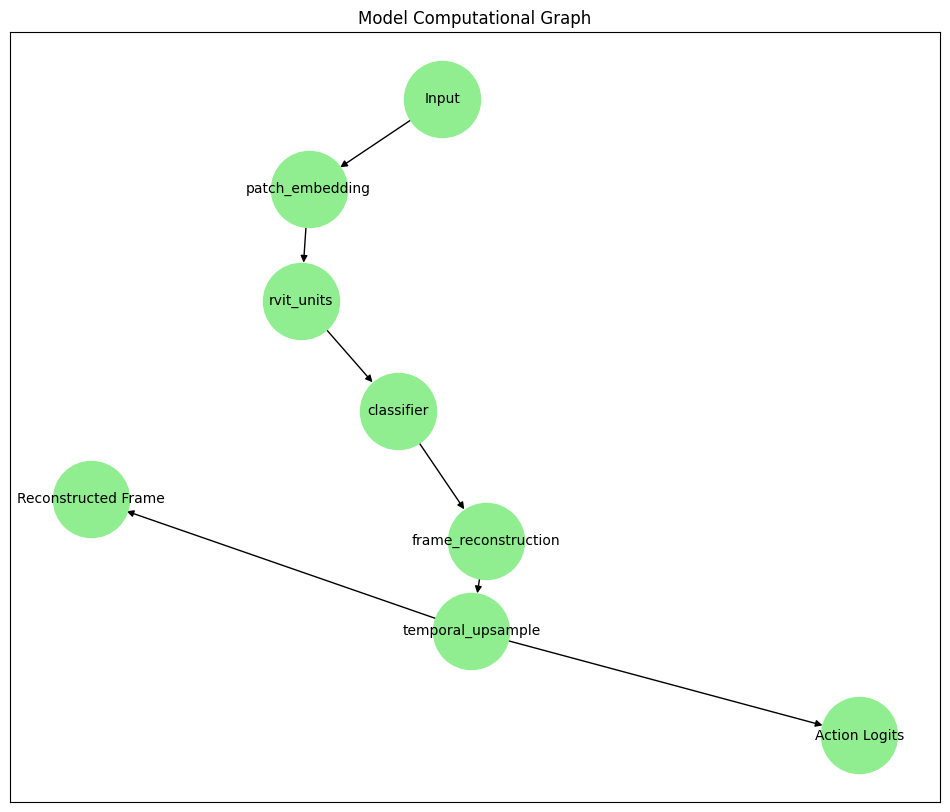

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# Define a function to extract model structure and create a graph
def create_model_graph(model):
    graph = nx.DiGraph()
    previous_node = "Input"
    graph.add_node(previous_node)
    
    # Traverse the model's modules
    for name, module in model.named_children():
        current_node = name
        graph.add_edge(previous_node, current_node)
        previous_node = current_node
    
    # Add output nodes
    graph.add_edge(previous_node, "Action Logits")
    graph.add_edge(previous_node, "Reconstructed Frame")
    
    return graph

# Create the graph for the model
model_graph = create_model_graph(model)

# Draw the graph
plt.figure(figsize=(12, 10))
nx.draw_networkx(
    model_graph, 
    with_labels=True, 
    node_size=3000, 
    node_color='lightgreen', 
    font_size=10
)
plt.title("Model Computational Graph")
plt.show()


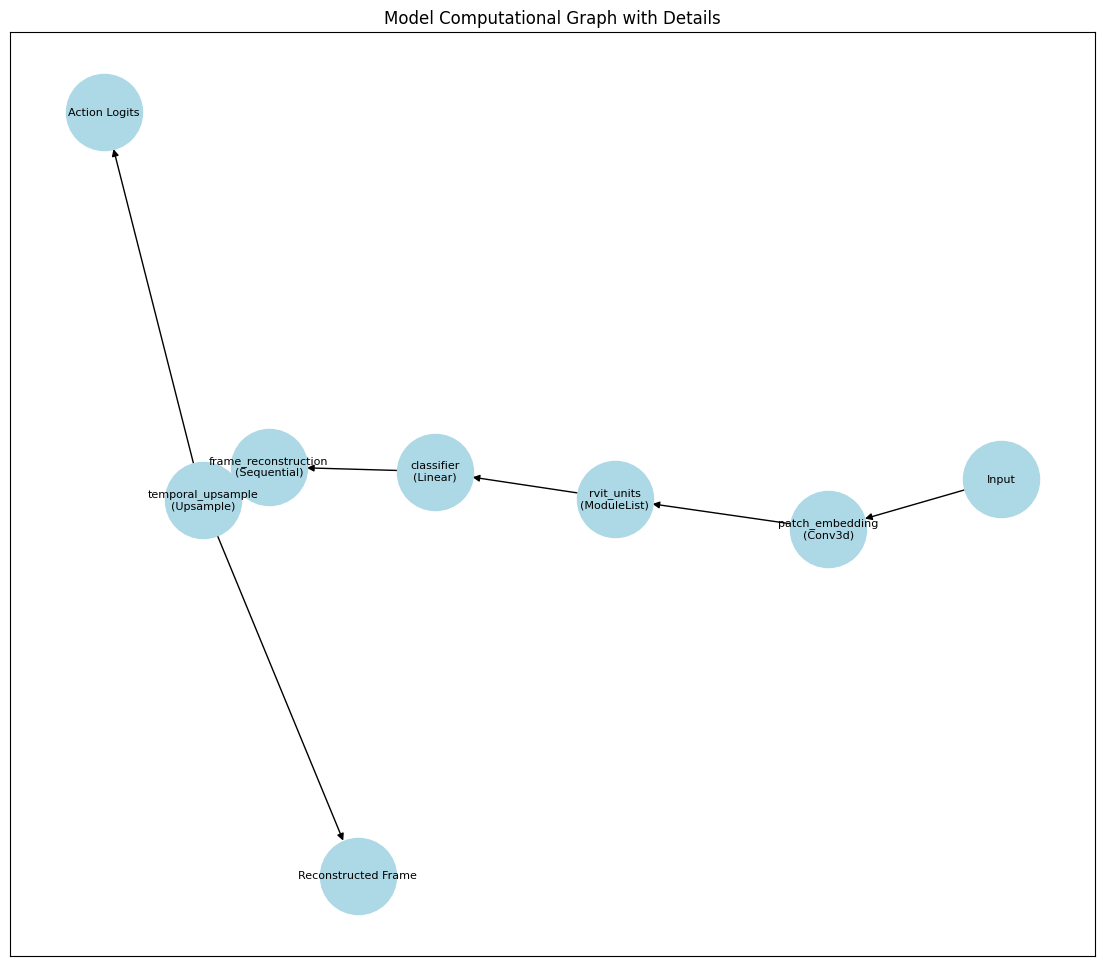

In [12]:
def create_model_graph_with_details(model):
    graph = nx.DiGraph()
    previous_node = "Input"
    graph.add_node(previous_node)
    
    # Traverse model modules with details
    for name, module in model.named_children():
        current_node = f"{name}\n({module.__class__.__name__})"
        graph.add_edge(previous_node, current_node)
        previous_node = current_node
    
    # Add output nodes
    graph.add_edge(previous_node, "Action Logits")
    graph.add_edge(previous_node, "Reconstructed Frame")
    
    return graph

# Create the graph with details
detailed_graph = create_model_graph_with_details(model)

# Draw the graph
plt.figure(figsize=(14, 12))
nx.draw_networkx(
    detailed_graph, 
    with_labels=True, 
    node_size=3000, 
    node_color='lightblue', 
    font_size=8
)
plt.title("Model Computational Graph with Details")
plt.show()


In [13]:
from torch.utils.tensorboard import SummaryWriter
import torch

# Create a writer
writer = SummaryWriter("runs/rvit_experiment")

# Dummy input tensor
x = torch.randn(1, 16, 32, 112, 112)

# Log the graph
writer.add_graph(model, x)
writer.close()


After patch embedding: torch.Size([1, 128, 11, 28, 28])
Position encoding shape after interpolation: torch.Size([1, 128, 11, 28, 28])
After adding position encoding: torch.Size([1, 128, 11, 28, 28])
Initialized recurrent state: torch.Size([1, 128, 11, 28, 28])
After RViT unit 1: torch.Size([1, 128, 11, 28, 28])
After RViT unit 2: torch.Size([1, 128, 11, 28, 28])
Action logits shape: torch.Size([1, 10])
Reconstructed frame shape: torch.Size([1, 3, 11, 28, 28])
After patch embedding: torch.Size([1, 128, 11, 28, 28])
Position encoding shape after interpolation: torch.Size([1, 128, 11, 28, 28])
After adding position encoding: torch.Size([1, 128, 11, 28, 28])
Initialized recurrent state: torch.Size([1, 128, 11, 28, 28])
After RViT unit 1: torch.Size([1, 128, 11, 28, 28])
After RViT unit 2: torch.Size([1, 128, 11, 28, 28])
Action logits shape: torch.Size([1, 10])
Reconstructed frame shape: torch.Size([1, 3, 11, 28, 28])
After patch embedding: torch.Size([1, 128, 11, 28, 28])
Position encodin

In [20]:
x = torch.randn(1, 16, 32, 112, 112)  # Dummy input tensor
model = RViT(num_classes=10, hidden_dim=128, num_layers=2, frame_dim=(3, 112, 112))
output = model(x)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RViT(num_classes=len(label_to_index), hidden_dim=256, num_layers=2, frame_dim=(3, 224, 224)).to(device)

In [22]:
import gc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image


In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [24]:
# Incorporate mixed-precision training with GradScaler
scaler = torch.cuda.amp.GradScaler()

# Criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training and validation
num_epochs = 10
accumulation_steps = 4

# Initialize lists to store loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    optimizer.zero_grad()
    
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            action_logits, _ = model(inputs)
            loss = criterion(action_logits, labels) / accumulation_steps

        # Backward pass with scaling
        scaler.scale(loss).backward()

        # Gradient accumulation step
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        # Update running loss and corrects
        running_loss += loss.item() * accumulation_steps * inputs.size(0)
        _, preds = torch.max(action_logits, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}')
    
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                action_logits, _ = model(inputs)
                loss = criterion(action_logits, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(action_logits, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    print(f'Validation Loss: {val_epoch_loss:.4f} - Validation Acc: {val_epoch_acc:.4f}')
    
    # Clear GPU cache
    torch.cuda.empty_cache()
    gc.collect()

C:\Users\jeffr\AppData\Local\Temp\ipykernel_10108\4168693922.py:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
c:\Users\jeffr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


: 